### Predicting Multipartite and Unipartite genome based on genes present on respective genomes

Following is a machine learning framework that uses a set of genes present in Multipartite and Unipartite Genomes to predict the phenotype and prioritize the most important genes that separate the respective phenotype

Jupyter Notebook by: Janak Sunuwar

In [1]:
# filename = input file
file_name = 'https://github.com/Janaksunuwar/Predicting-Multipartite-and-Unipartite-Bacterial-Genomes/raw/main/Data/Final_Multipartite_Gene_Level_Matrix.csv'

# Result out
file_all_out = "1.Final_Multipartite_Gene_Level_All_Out.csv"

# level of run
level = 'Gene_Level'


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
np.random.seed(1)
import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

#Import classifiers
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score

#read the csv file
data = pd.read_csv(file_name)
row = len(data)
column = len(data.columns)
#select the features beside the label
X = data.iloc[:, 1:-2] 
#select the label/pehnotype column
Y = data.iloc[:,-1]


#create a dataframe for the final output of the program
Tf_CV = pd.DataFrame(columns=[])
Training_Performance = pd.DataFrame(columns=[])
Test_Performance = pd.DataFrame(columns=[])
Area_Under_ROC = pd.DataFrame(columns=[])
Area_Under_Precision_Recall = pd.DataFrame(columns=[])

#split the dataset into six equal parts
kf = KFold(n_splits=6)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    #Build model and evaluate models
    models = []
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))
    
    #Evaluate each model
    myDF = pd.DataFrame(columns=[])
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
        mean= results.mean().round(3)
        std = results.std()
        myDF = myDF.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
    Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

    #TRAINING PERFORMANCE
    myDF1 = pd.DataFrame(columns=[])
    for name, model in models:    
        model = model.fit(X_train, Y_train)
        Y_train_pred = model.predict(X_train)
        Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
        myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
    Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
 
    #TEST PERFORMANCE
    myDF2 = pd.DataFrame(columns=[])
    for name, model in models:  
        model = model.fit(X_train, Y_train)
        Y_test_pred = model.predict(X_test)
        report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
        Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
        myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
    Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
    
    #AU_ROC
    myDF3 = pd.DataFrame(columns=[])
    for name, model in models:
        model = model.fit(X_train, Y_train)
        y_pred_proba = model.predict_proba(X_test)[::,1]
        # keep probabilities for the positive outcome only
        fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
        a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
        myDF3 = myDF3.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
    Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)
    
    #Area Under precision recall curve
    myDF4 = pd.DataFrame(columns=[])
    for name, model in models:
        #predict probabilities
        y_pred_proba = model.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        y_pred_proba = y_pred_proba[:, 1]
        #predict class vlaues
        y_pred = model.predict(X_test)
        # calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
        # calculate au precision-recall curve
        area = auc(recall, precision).round(3)
        # calculate f1 score
        f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
        myDF4 = myDF4.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
    Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
    i += 1
    
#Model names
Models = Tf_CV.iloc[:, 0] 

#Calculating the mean of all folds
#training f1 average
tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3).rename('tr_f1_avg_as', inplace=True)
tr_f1_stdev = Training_Performance[Training_Performance.columns[1::4]].std(axis=1).round(3).rename('tr_f1_stdev_as', inplace=True)

#Training precision average
tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3).rename('tr_precision_avg_as', inplace=True)
tr_precision_stdev = Training_Performance[Training_Performance.columns[2::4]].std(axis=1).round(3).rename('tr_precision_stdev_as', inplace=True)

#Training recall average
tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3).rename('tr_recall_avg_as', inplace=True)
tr_recall_stdev = Training_Performance[Training_Performance.columns[3::4]].std(axis=1).round(3).rename('tr_recall_stdev_as', inplace=True)

#Test f1 average
te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3).rename('te_f1_avg_as', inplace=True)
te_f1_stdev = Test_Performance[Test_Performance.columns[1::4]].std(axis=1).round(3).rename('te_f1_stdev_as', inplace=True)

#Test precision average
te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3).rename('te_precision_avg_as', inplace=True)
te_precision_stdev = Test_Performance[Test_Performance.columns[2::4]].std(axis=1).round(3).rename('te_precision_stdev_as', inplace=True)

#Test recall average
te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3).rename('te_recall_avg_as', inplace=True)
te_recall_stdev = Test_Performance[Test_Performance.columns[3::4]].std(axis=1).round(3).rename('te_recall_stdev_as', inplace=True)

#Tf_CV average
Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3).rename('Tf_CV_Avg_as', inplace=True)
Tf_CV_stdev = Tf_CV[Tf_CV.columns[1::2]].std(axis=1).round(3).rename('Tf_CV_stdev_as', inplace=True)

#Area_Under_ROC average
au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3).rename('au_ROC_avg_as', inplace=True)
au_ROC_stdev = Area_Under_ROC[Area_Under_ROC.columns[1::2]].std(axis=1).round(3).rename('au_ROC_stdev_as', inplace=True)

#Area_Under_Precision_Recall average
au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3).rename('au_PR_avg_as', inplace=True)
au_PR_stdev= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].std(axis=1).round(3).rename('au_PR_stdev_as', inplace=True)

#Accumulating all dataframes
frames2 = [Models, 
           tr_precision_avg, tr_precision_stdev, tr_recall_avg, tr_recall_stdev, tr_f1_avg, tr_f1_stdev, 
           te_precision_avg, te_precision_stdev, te_recall_avg, te_recall_stdev, te_f1_avg, te_f1_stdev,
           Tf_CV_Avg, Tf_CV_stdev, au_ROC_avg, au_ROC_stdev, au_PR_avg, au_PR_stdev]

#Result all set
Final_All_set_Results= pd.concat(frames2, axis=1)

with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nResults_All_Set_Multipartite_{level}\n')
    Result_file.write(f"The matrix size {row} X {column}")
    Final_All_set_Results.to_csv(Result_file)
    
#Export results separately
Final_All_set_Results.to_csv(f'Multipartite_{level}_All_Set_Performance.csv', encoding='utf-8')
   
print('All Set Performance')
display (Final_All_set_Results)
    
#FEATURE IMPORTANCE to get consistent genes=Target genes in 6 Folds
import pandas as pd
#We can use the folds from K-Fold as an iterator 
#and use it in a for loop to perform the training on a pandas dataframe
#Defin the KFold class and train the model
from sklearn.model_selection import KFold
kf = KFold(n_splits = 6)
clfk = LogisticRegression(random_state=1)
model_names = 'LR'
myDF5 = pd.DataFrame(columns=[])
scores = []
test_scores = []
check_feat = []

Output = pd.DataFrame()
kf = KFold(n_splits=6)
j = 0
for train_index, test_index in kf.split(X):
    myDF51= pd.DataFrame(columns=[])
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    modelk = clfk.fit(X_train,Y_train)
    predictions = clfk.predict(X_test)
    scores.append(clfk.score(X_test, Y_test))
    # feature importance logistic regression
    feat = list(clfk.coef_.T)
    # select the column header from first to the second last
    colhead = list(np.array([data.columns[1:-1]]).T)
    # zip tow columns into a dataframe
    list_of_tuplesk= list(zip(colhead, feat))
    # create a dataframe
    feature_importancek = pd.DataFrame(list_of_tuplesk, columns = [f'Feature fold{j}', f'Importance fold{j}'])
    # sort the dataframe, descending
    feature_importance_sortedk = feature_importancek.sort_values(by=f'Importance fold{j}', ascending=False)
    # remove the square brackets from the dataframe
    feature_importance_sortedk [f'Feature fold{j}'] = feature_importance_sortedk[f'Feature fold{j}'].str.get(0)
    feature_importance_sortedk = feature_importance_sortedk.round(3)
        
    test_df = pd.DataFrame(feature_importance_sortedk)
    test_df.reset_index(drop=True, inplace=True)
    myDF5.reset_index(drop=True, inplace=True)
    myDF5 = pd.concat([myDF5, test_df], axis= 1)
    j += 1

# select the number of top genes in the list
top_genes_no = 200
# make dataframe of selected top dataframes
Top_consistent = myDF5.iloc[0:top_genes_no, :]

# separate each column to separate dataframe and find common in all
cdf1 = Top_consistent[['Feature fold0']].rename(columns={"Feature fold0": "Feature"})
cdf2 = Top_consistent[['Feature fold1']].rename(columns={"Feature fold1": "Feature"})
cdf3 = Top_consistent[['Feature fold2']].rename(columns={"Feature fold2": "Feature"})
cdf4 = Top_consistent[['Feature fold3']].rename(columns={"Feature fold3": "Feature"})
cdf5 = Top_consistent[['Feature fold4']].rename(columns={"Feature fold4": "Feature"})
cdf6 = Top_consistent[['Feature fold5']].rename(columns={"Feature fold5": "Feature"})

merge12 = pd.merge(cdf1, cdf2, how='inner', on=['Feature'])
merge123 = pd.merge(merge12, cdf3, how='inner', on=['Feature'])
merge1234 = pd.merge(merge123, cdf4, how='inner', on=['Feature'])
merge12345 = pd.merge(merge1234, cdf5, how='inner', on=['Feature'])
Final_Consistent_Genes_Multipartite = pd.merge(merge12345, cdf6, how='inner', on=['Feature'])

#Export to all file out result file
with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nNo. of Top genes {top_genes_no} {level}\n')
    Result_file.write(f'\nFinal_Consistent_Genes_Multipartite_{level}\n')
    Final_Consistent_Genes_Multipartite.to_csv(Result_file)
    
# export separate consistent genes names
Final_Consistent_Genes_Multipartite.to_csv(f'2.Final_Consistent_Genes_Multipartite_{level}.csv', encoding='utf-8')

#########################################
#INTERSECTION RUN

data = pd.read_csv(file_name)
#read gene_ast matrix
open_gene_ast = pd.read_csv(file_name)
# read file to dataframe
open_consistent_genes = pd.read_csv(f'2.Final_Consistent_Genes_Multipartite_{level}.csv')

# make separate dataframe with just consistent genes
target_genesTT = open_consistent_genes[['Feature']].rename(columns={'Feature': 'Consistent genes'})

#No of top consistent genes
num = 15
target_genesTT = target_genesTT.iloc[:num, :]

# sort the consistent genes 
target_genesTT = target_genesTT.sort_values('Consistent genes')
# adding antibiotic lable at the end
target_genes_good = target_genesTT.append({'Consistent genes': 'Label'}, ignore_index=True)
# converting consistent genes to a list
column_list = target_genes_good['Consistent genes'].tolist()

#ALL DATA
#make gene, ast matrix consisting only of consistent genes 
data = open_gene_ast[column_list]

X= data.iloc[:, 1:-1]
Y = data.iloc[:,-1]

#create a dataframe for the final output of the program
Tf_CV = pd.DataFrame(columns=[])
Training_Performance = pd.DataFrame(columns=[])
Test_Performance = pd.DataFrame(columns=[])
Area_Under_ROC = pd.DataFrame(columns=[])
Area_Under_Precision_Recall = pd.DataFrame(columns=[])

kf = KFold(n_splits=6)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    #Build model and evaluate models
    models = []
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))
    
    myDF = pd.DataFrame(columns=[])
    #Evaluate each model
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
        mean= results.mean().round(3)
        std = results.std()
        myDF = myDF.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
    Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

    #TRAINING PERFORMANCE
    myDF1 = pd.DataFrame(columns=[])
    for name, model in models:    
        model = model.fit(X_train, Y_train)
        Y_train_pred = model.predict(X_train)
        Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
        myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
    Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
 
    #TEST PERFORMANCE
    myDF2 = pd.DataFrame(columns=[])
    for name, model in models:  
        model = model.fit(X_train, Y_train)
        Y_test_pred = model.predict(X_test)
        report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
        Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
        myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
    Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
    
    #AU_ROC
    myDF3 = pd.DataFrame(columns=[])
    for name, model in models:
        model = model.fit(X_train, Y_train)
        y_pred_proba = model.predict_proba(X_test)[::,1]
        # keep probabilities for the positive outcome only
        
        fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
        a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
        myDF3 = myDF3.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
    Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)
    
    #Area under precision recall
    myDF4 = pd.DataFrame(columns=[])
    for name, model in models:
        #predict probabilities
        y_pred_proba = model.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        y_pred_proba = y_pred_proba[:, 1]
        #predict class vlaues
        y_pred = model.predict(X_test)
        # calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
        # calculate au precision-recall curve
        area = auc(recall, precision).round(3)
        # calculate f1 score
        f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
        myDF4 = myDF4.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
    Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
    i += 1
    
#Model names
Models = Tf_CV.iloc[:, 0] 

#training f1 average
tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3).rename('tr_f1_avg_is', inplace=True)
tr_f1_stdev = Training_Performance[Training_Performance.columns[1::4]].std(axis=1).round(3).rename('tr_f1_stdev_is', inplace=True)


#Training precision average
tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3).rename('tr_precision_avg_is', inplace=True)
tr_precision_stdev = Training_Performance[Training_Performance.columns[2::4]].std(axis=1).round(3).rename('tr_precision_stdev_is', inplace=True)


#Training recall average
tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3).rename('tr_recall_avg_is', inplace=True)
tr_recall_stdev = Training_Performance[Training_Performance.columns[3::4]].std(axis=1).round(3).rename('tr_recall_stdev_is', inplace=True)


#Test f1 average
te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3).rename('te_f1_avg_is', inplace=True)
te_f1_stdev = Test_Performance[Test_Performance.columns[1::4]].std(axis=1).round(3).rename('te_f1_stdev_is', inplace=True)


#Test precision average
te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3).rename('te_precision_avg_is', inplace=True)
te_precision_stdev = Test_Performance[Test_Performance.columns[2::4]].std(axis=1).round(3).rename('te_precision_stdev_is', inplace=True)


#Test recall average
te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3).rename('te_recall_avg_is', inplace=True)
te_recall_stdev = Test_Performance[Test_Performance.columns[3::4]].std(axis=1).round(3).rename('te_recall_stdev_is', inplace=True)

#Tf_CV average
Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3).rename('Tf_CV_Avg_is', inplace=True)
Tf_CV_stdev = Tf_CV[Tf_CV.columns[1::2]].std(axis=1).round(3).rename('Tf_CV_stdev_is', inplace=True)

#Area_Under_ROC average
au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3).rename('au_ROC_avg_is', inplace=True)
au_ROC_stdev = Area_Under_ROC[Area_Under_ROC.columns[1::2]].std(axis=1).round(3).rename('au_ROC_stdev_is', inplace=True)

#Area_Under_Precision_Recall average
au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3).rename('au_PR_avg_is', inplace=True)
au_PR_stdev= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].std(axis=1).round(3).rename('au_PR_stdev_is', inplace=True)

#Accumulating all dataframes
frames2 = [Models, 
           tr_precision_avg, tr_precision_stdev, tr_recall_avg, tr_recall_stdev, tr_f1_avg, tr_f1_stdev, 
           te_precision_avg, te_precision_stdev, te_recall_avg, te_recall_stdev, te_f1_avg, te_f1_stdev,
           Tf_CV_Avg, Tf_CV_stdev, au_ROC_avg, au_ROC_stdev, au_PR_avg, au_PR_stdev]

#Result all set
Final_Intersection_set_Results= pd.concat(frames2, axis=1)

with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nIntersection Multipartite {level}\n')
    Result_file.write(f'\nNo. of top consistent gene {num}')
    Final_Intersection_set_Results.to_csv(Result_file)

# export separate Intersection results
Final_Intersection_set_Results.to_csv(f'3.Multipartite_{level}_Intersection_Set_Performance.csv', encoding='utf-8')

print('Intersection Set Performance')
display(Final_Intersection_set_Results)

###############################################
#Random Set Run
num = 15
#read data
daa = pd.read_csv(file_name)
label = daa[['Label']]
daa = daa.drop(['Accessions', 'Label'], axis=1)
view_daa = daa.iloc[:, [0,1,2,3,-3, -2,-1]]

#Create a dataframe for the final output of the program
Random_Set_Results = pd.DataFrame(columns=[])

#Select 10 random sets
for k in range(10):
    samp = daa.sample(n=num, replace = False, axis=1)
    data = pd.concat([samp, label], axis=1)
    X = data.iloc[:, 1:num]
    Y = data.iloc[:,-1]

    #Dataframes for results
    Tf_CV = pd.DataFrame(columns=[])
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])
    kf = KFold(n_splits=10)
    ij = 0

    #Split the data
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build model and evaluate models
        models = []
        models.append(('LogR', LogisticRegression(max_iter=10000)))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))

        #Training performance
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{ij+1}': Tr_precision, f'tr_recall{ij+1}': Tr_recall, f'tr_f1 {ij+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

        #Test performance
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred).round(3)
            Te_recall = recall_score(Y_test, Y_test_pred).round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{ij+1}': Te_precision, f'te_recall{ij+1}': Te_recall, f'te_f1 {ij+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

        #Ten-fold cross validation
        myDF = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean= results.mean().round(3)
            std = results.std()
            myDF = myDF.append({'classifier': name, f'ten_f_CV{ij+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

        #AU_ROC
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            # keep probabilities for the positive outcome only

            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF3 = myDF3.append({'classifier': name, f'au ROC {ij+1}': a_u_c}, ignore_index = True)

        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)

        #AUPR
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
            myDF4 = myDF4.append({'classifier': name, f'au PR {ij+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
        ij += 1

    #List for output
    myDF5 = pd.DataFrame(columns=[])

    #Model names
    Models = Tf_CV.iloc[:, 0]

    #Training_Performance F1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename(f'tr_f1_avg_{k}', inplace=True)

    #Training_Performance precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename(f'tr_precision_avg_{k}', inplace=True)

    #Training_Performance recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename(f'tr_recall_avg_{k}', inplace=True)

    #Test_Performance f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename(f'te_f1_avg_{k}', inplace=True)

    #Test_Performance precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename(f'te_precision_avg_{k}', inplace=True)

    #Test_Performance recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename(f'te_recall_avg_{k}', inplace=True)

    #Ten fold crossvalidation average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename(f'Tf_CV_Avg_{k}', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg_rs = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
    au_ROC_avg_rs = au_ROC_avg_rs.rename(f'au_ROC_avg_{k}', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg_rs = Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
    au_PR_avg_rs = au_PR_avg_rs.rename(f'au_PR_avg_{k}', inplace=True)

    #Concatenate results
    frames1 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg_rs, au_PR_avg_rs]
    Ran_Resul = pd.concat(frames1, axis=1)
    Random_Set_Results = pd.concat([Random_Set_Results, Ran_Resul], axis =1)
    k +=1

#Calculating average for outer 10 random sets from nested inner fold validation 
Models = pd.DataFrame(Models)

#Training_Performance precision average
tr_pa = Random_Set_Results[Random_Set_Results.columns[1::10]].mean(axis=1).round(3).rename('tr_precision_avg_rs', inplace=True)
tr_pa_stdev = Random_Set_Results[Random_Set_Results.columns[1::10]].std(axis=1).round(3).rename('tr_precision_stdev_rs', inplace=True)
tr_pa = pd.DataFrame(tr_pa)
tr_pa_stdev = pd.DataFrame(tr_pa_stdev)

#Training_Performance recall average
tr_ra = Random_Set_Results[Random_Set_Results.columns[2::10]].mean(axis=1).round(3).rename('tr_recall_avg_rs', inplace=True)
tr_ra_stdev = Random_Set_Results[Random_Set_Results.columns[2::10]].std(axis=1).round(3).rename('tr_recall_stdev_rs', inplace=True)
tr_ra = pd.DataFrame(tr_ra)
tr_ra_stdev = pd.DataFrame(tr_ra_stdev)

#Training_Performance F1 average
tr_fa = Random_Set_Results[Random_Set_Results.columns[3::10]].mean(axis=1).round(3).rename('tr_f1_avg_rs', inplace=True)
tr_fa_stdev = Random_Set_Results[Random_Set_Results.columns[3::10]].std(axis=1).round(3).rename('tr_f1_stdev_rs', inplace=True)
tr_fa = pd.DataFrame(tr_fa)
tr_fa_stdev = pd.DataFrame(tr_fa_stdev)

#Test_Performance precision average
te_pa = Random_Set_Results[Random_Set_Results.columns[4::10]].mean(axis=1).round(3).rename('te_precision_avg_rs', inplace=True)
te_pa_stdev = Random_Set_Results[Random_Set_Results.columns[4::10]].std(axis=1).round(3).rename('te_precision_stdev_rs', inplace=True)
te_pa = pd.DataFrame(te_pa)
te_pa_stdev = pd.DataFrame(te_pa_stdev)

#Test_Performance recall average
te_ra = Random_Set_Results[Random_Set_Results.columns[5::10]].mean(axis=1).round(3).rename('te_recall_avg_rs', inplace=True)
te_ra_stdev = Random_Set_Results[Random_Set_Results.columns[5::10]].std(axis=1).round(3).rename('te_recall_stdev_rs', inplace=True)
tr_ra = pd.DataFrame(tr_ra)
te_ra_stdev = pd.DataFrame(te_ra_stdev)

#Test_Performance f1 average
te_fa = Random_Set_Results[Random_Set_Results.columns[6::10]].mean(axis=1).round(3).rename('te_f1_avg_rs', inplace=True)
te_fa_stdev = Random_Set_Results[Random_Set_Results.columns[6::10]].std(axis=1).round(3).rename('te_f1_stdev_rs', inplace=True)
te_fa = pd.DataFrame(te_fa)
te_fa_stdev = pd.DataFrame(te_fa_stdev)

#Ten fold crossvalidation average
Tf_Ca = Random_Set_Results[Random_Set_Results.columns[7::10]].mean(axis=1).round(3).rename('Tf_CV_Avg_rs', inplace=True)
Tf_Ca_stdev = Random_Set_Results[Random_Set_Results.columns[7::10]].std(axis=1).round(3).rename('Tf_CV_stdev_rs', inplace=True)
Tf_Ca = pd.DataFrame(Tf_Ca)
Tf_Ca_stdev = pd.DataFrame(Tf_Ca_stdev)

#Area_Under_ROC average
au_Ra = Random_Set_Results[Random_Set_Results.columns[8::10]].mean(axis=1).round(3).rename('au_ROC_avg_rs', inplace=True)
au_Ra_stdev = Random_Set_Results[Random_Set_Results.columns[8::10]].std(axis=1).round(3).rename('au_ROC_stdev_rs', inplace=True)
au_Ra = pd.DataFrame(au_Ra)
au_Ra_stdev = pd.DataFrame(au_Ra_stdev)

#Area_Under_Precision_Recall average
au_Pa = Random_Set_Results[Random_Set_Results.columns[9::10]].mean(axis=1).round(3).rename('au_PR_avg_rs', inplace=True)
au_Pa_stdev = Random_Set_Results[Random_Set_Results.columns[9::10]].std(axis=1).round(3).rename('au_PR_stdev_rs', inplace=True)
au_Pa = pd.DataFrame(au_Pa)
au_Pa_stdev = pd.DataFrame(au_Pa_stdev)

#Concatenate results
Final_Random_Set_Results = pd.concat([Models, 
                                      tr_pa, tr_pa_stdev, tr_ra, tr_ra_stdev, tr_fa, tr_fa_stdev, 
                                      te_pa, te_pa_stdev, te_ra, te_ra_stdev, te_fa, te_fa_stdev,  
                                      Tf_Ca, Tf_Ca_stdev,
                                      au_Ra, au_Ra_stdev, au_Pa, au_Pa_stdev], axis=1)

print('Random Set Results')
display(Final_Random_Set_Results)

with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nRandom Gene Level Multipartite\n')
    Final_Random_Set_Results.to_csv(Result_file)

# export separate random results
Final_Random_Set_Results.to_csv(f'4.Multipartite_{level}_Random_Set_Performance.csv', encoding='utf-8')


All Set Performance


,classifier,tr_precision_avg_as,tr_precision_stdev_as,tr_recall_avg_as,tr_recall_stdev_as,tr_f1_avg_as,tr_f1_stdev_as,te_precision_avg_as,te_precision_stdev_as,te_recall_avg_as,te_recall_stdev_as,te_f1_avg_as,te_f1_stdev_as,Tf_CV_Avg_as,Tf_CV_stdev_as,au_ROC_avg_as,au_ROC_stdev_as,au_PR_avg_as,au_PR_stdev_as
0,LogR,1.000,0.000,1.000,0.000,1.000,0.000,0.688,0.220,0.588,0.307,0.565,0.365,0.777,0.056,0.806,0.267,0.792,0.278
1,gNB,1.000,0.000,1.000,0.000,1.000,0.000,0.688,0.234,0.616,0.290,0.648,0.333,0.812,0.069,0.688,0.234,0.765,0.286
2,SVM,1.000,0.000,1.000,0.000,1.000,0.000,0.701,0.227,0.611,0.323,0.582,0.380,0.777,0.049,0.861,0.155,0.780,0.269
3,DT,1.000,0.000,1.000,0.000,1.000,0.000,0.653,0.267,0.586,0.310,0.578,0.351,0.704,0.060,0.653,0.267,0.780,0.166
4,RF,1.000,0.000,1.000,0.000,1.000,0.000,0.660,0.179,0.562,0.270,0.548,0.342,0.738,0.057,0.861,0.155,0.792,0.269
5,KNN,0.953,0.042,0.952,0.043,0.954,0.042,0.785,0.205,0.743,0.268,0.793,0.294,0.789,0.048,0.764,0.335,0.776,0.308
6,LDA,0.723,0.035,0.723,0.034,0.726,0.036,0.590,0.152,0.507,0.199,0.526,0.259,0.665,0.035,0.820,0.213,0.770,0.270
7,mNB,1.000,0.000,1.000,0.000,1.000,0.000,0.646,0.253,0.598,0.289,0.642,0.345,0.786,0.051,0.771,0.139,0.728,0.241
8,ABC,1.000,0.000,1.000,0.000,1.000,0.000,0.701,0.245,0.643,0.296,0.655,0.342,0.774,0.070,0.680,0.442,0.728,0.375
9,GBC,1.000,0.000,1.000,0.000,1.000,0.000,0.680,0.228,0.608,0.289,0.604,0.330,0.718,0.061,0.806,0.193,0.849,0.133


Intersection Set Performance


,classifier,tr_precision_avg_is,tr_precision_stdev_is,tr_recall_avg_is,tr_recall_stdev_is,tr_f1_avg_is,tr_f1_stdev_is,te_precision_avg_is,te_precision_stdev_is,te_recall_avg_is,te_recall_stdev_is,te_f1_avg_is,te_f1_stdev_is,Tf_CV_Avg_is,Tf_CV_stdev_is,au_ROC_avg_is,au_ROC_stdev_is,au_PR_avg_is,au_PR_stdev_is
0,LogR,0.933,0.024,0.933,0.023,0.934,0.024,0.882,0.122,0.870,0.129,0.910,0.072,0.858,0.029,0.972,0.068,0.985,0.038
1,gNB,0.971,0.019,0.971,0.018,0.974,0.016,0.771,0.229,0.705,0.309,0.696,0.354,0.818,0.099,0.840,0.201,0.902,0.122
2,SVM,0.981,0.015,0.981,0.015,0.982,0.014,0.854,0.184,0.822,0.235,0.818,0.268,0.868,0.029,0.972,0.068,0.985,0.038
3,DT,1.000,0.000,1.000,0.000,1.000,0.000,0.875,0.194,0.846,0.246,0.839,0.278,0.856,0.044,0.875,0.194,0.922,0.113
4,RF,1.000,0.000,1.000,0.000,1.000,0.000,0.854,0.184,0.822,0.235,0.818,0.268,0.857,0.044,0.972,0.068,0.985,0.038
5,KNN,0.890,0.022,0.890,0.021,0.892,0.021,0.882,0.122,0.870,0.129,0.910,0.072,0.875,0.023,0.910,0.072,0.934,0.058
6,LDA,0.995,0.012,0.995,0.012,0.996,0.011,0.715,0.187,0.672,0.244,0.716,0.288,0.857,0.049,0.792,0.252,0.777,0.258
7,mNB,0.855,0.098,0.854,0.100,0.868,0.091,0.715,0.248,0.660,0.296,0.697,0.319,0.726,0.080,0.889,0.172,0.843,0.257
8,ABC,1.000,0.000,1.000,0.000,1.000,0.000,0.882,0.110,0.878,0.110,0.893,0.108,0.861,0.047,0.972,0.068,0.985,0.038
9,GBC,1.000,0.000,1.000,0.000,1.000,0.000,0.903,0.131,0.894,0.139,0.930,0.078,0.875,0.053,0.958,0.065,0.970,0.051


Random Set Results


,classifier,tr_precision_avg_rs,tr_precision_stdev_rs,tr_recall_avg_rs,tr_recall_stdev_rs,tr_f1_avg_rs,tr_f1_stdev_rs,te_precision_avg_rs,te_precision_stdev_rs,te_recall_avg_rs,te_recall_stdev_rs,te_f1_avg_rs,te_f1_stdev_rs,Tf_CV_Avg_rs,Tf_CV_stdev_rs,au_ROC_avg_rs,au_ROC_stdev_rs,au_PR_avg_rs,au_PR_stdev_rs
0,LogR,0.734,0.240,0.728,0.108,0.819,0.140,0.615,0.334,0.527,0.246,0.498,0.215,0.624,0.095,0.659,0.112,0.781,0.093
1,gNB,0.814,0.227,0.720,0.096,0.750,0.128,0.745,0.279,0.554,0.176,0.461,0.127,0.573,0.056,0.608,0.123,0.734,0.106
2,SVM,0.743,0.237,0.738,0.109,0.833,0.153,0.540,0.294,0.500,0.259,0.500,0.255,0.631,0.119,0.576,0.209,0.678,0.157
3,DT,0.759,0.236,0.745,0.116,0.826,0.145,0.645,0.307,0.546,0.226,0.511,0.200,0.624,0.094,0.630,0.114,0.765,0.098
4,RF,0.806,0.207,0.761,0.101,0.799,0.134,0.690,0.274,0.571,0.201,0.521,0.188,0.615,0.097,0.643,0.107,0.768,0.088
5,KNN,0.740,0.242,0.675,0.091,0.731,0.176,0.625,0.279,0.496,0.158,0.446,0.112,0.589,0.098,0.607,0.111,0.774,0.061
6,LDA,0.780,0.225,0.747,0.105,0.804,0.136,0.675,0.279,0.557,0.205,0.509,0.187,0.610,0.097,0.630,0.112,0.746,0.110
7,mNB,0.529,0.216,0.601,0.162,0.884,0.092,0.470,0.165,0.425,0.164,0.429,0.171,0.558,0.088,0.670,0.088,0.746,0.079
8,ABC,0.779,0.224,0.747,0.099,0.805,0.138,0.685,0.274,0.566,0.199,0.516,0.181,0.612,0.093,0.625,0.109,0.753,0.102
9,GBC,0.787,0.244,0.753,0.112,0.816,0.155,0.700,0.283,0.582,0.191,0.538,0.161,0.622,0.092,0.634,0.103,0.754,0.102


Assessment of the performance of the machine learning algorithms in predicting Multipartite Vs. Unipartite genomes, gene level, under 6-fold cross validation settings. The preformance metrics i) training precision, ii) training recall, iii) training F1, iv) test precision, v) test recall, vi) test F1, vii) 10f CV (ten-fold cross validation), viii) au PR (area under precision recall curve), and ix) au ROC (area under ROC curve). 'All' denotes all genes for taraining (as in the cross-validation partioning), 'Intersection' refers to genes that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled genes.


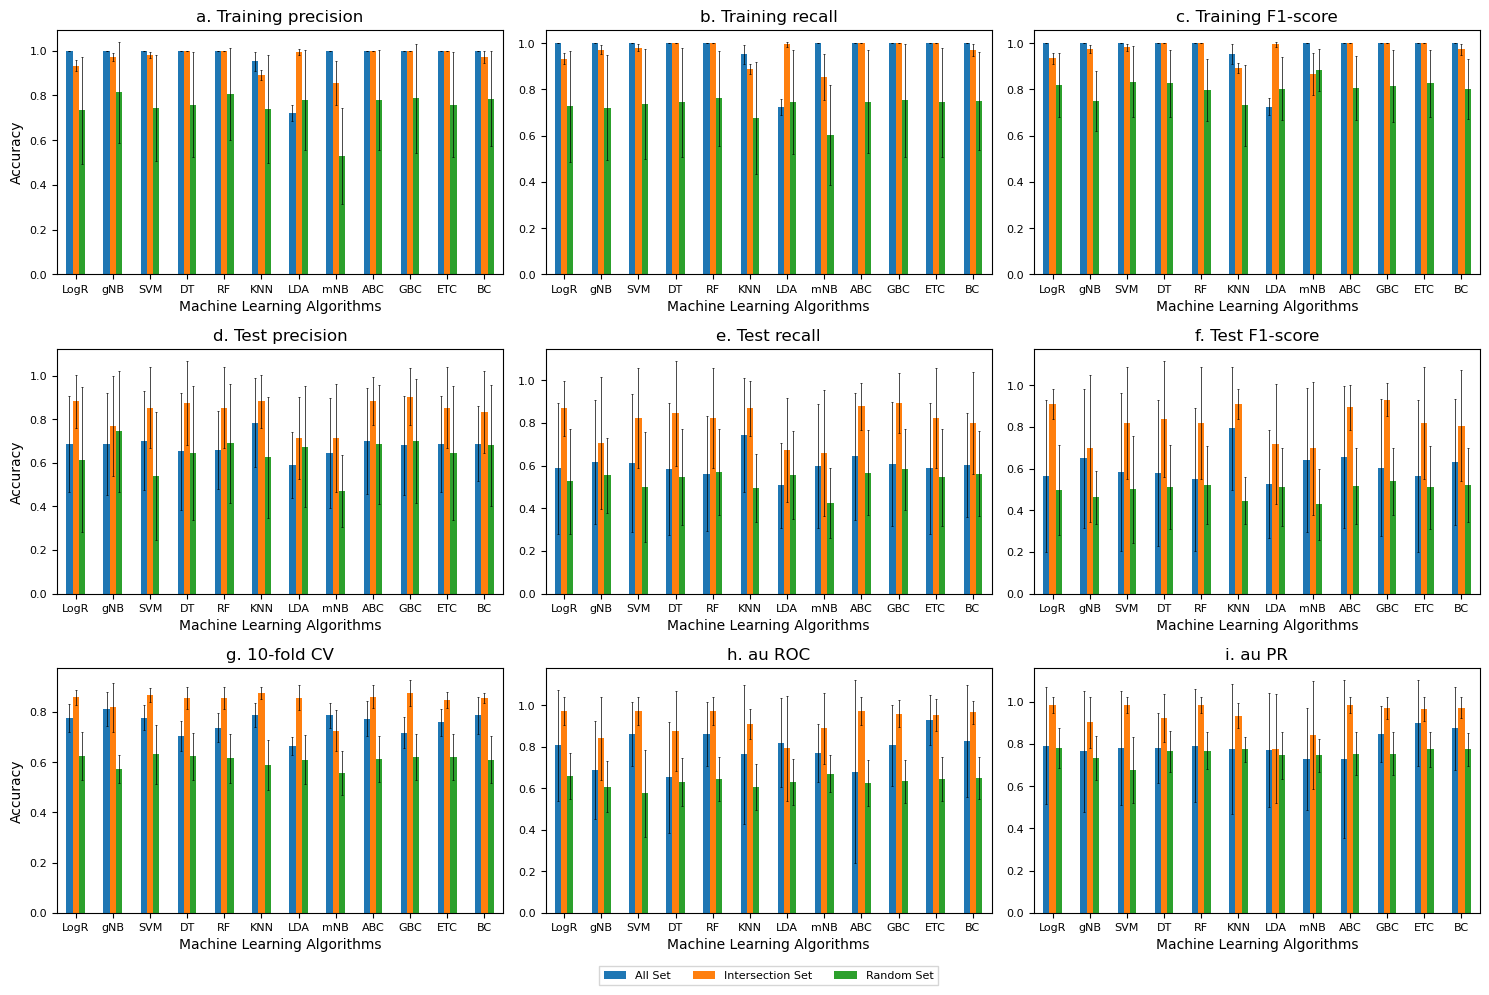

In [2]:
#Plot All set, Intersection set, Random set performance comparision figures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import rc
%matplotlib inline

level='Gene_Level'

#Open files to dataframe
d1 = pd.read_csv(f'Multipartite_{level}_All_Set_Performance.csv')
d2 = pd.read_csv(f'3.Multipartite_{level}_Intersection_Set_Performance.csv' )
d3 = pd.read_csv(f'4.Multipartite_{level}_Random_Set_Performance.csv')

#Select classifier names
models = d1[['classifier']]

#extract the average from All set, Intersection set, Random set performances
def extract_average(a, b, c):
    a_s = d1[[f'{a}']]
    i_s = d2[[f'{b}']]
    r_s = d3[[f'{c}']]
    df = pd.concat([models, a_s, i_s, r_s], axis =1)
    df.set_index(['classifier'], inplace=True)
    return df

#extraact the standard deviation for y-error
def extract_stdev(a, b, c):
    a_s_std = d1[[f'{a}']]
    i_s_std = d2[[f'{b}']]
    r_s_std = d3[[f'{c}']]
    df1_std = pd.concat([models, a_s_std, i_s_std, r_s_std], axis =1)
    df1_std.set_index(['classifier'], inplace=True)
    yerr_df1 = df1_std.iloc[:, :].to_numpy().T
    return df1_std, yerr_df1

#Training precision
Training_precision = extract_average('tr_precision_avg_as','tr_precision_avg_is', 'tr_precision_avg_rs')
#Training precision yerror
Training_precision_yerror =  extract_stdev('tr_precision_stdev_as', 'tr_precision_stdev_is','tr_precision_stdev_rs')[1]
#Training recall
Training_recall = extract_average('tr_recall_avg_as','tr_recall_avg_is', 'tr_recall_avg_rs')
#Training recall yerror
Training_recall_yerror = extract_stdev('tr_precision_stdev_as', 'tr_precision_stdev_is','tr_precision_stdev_rs')[1]
#Training F1
Training_F1 = extract_average('tr_f1_avg_as','tr_f1_avg_is', 'tr_f1_avg_rs')
#Training F1 yerror
Training_F1_yerror = extract_stdev('tr_f1_stdev_as', 'tr_f1_stdev_is','tr_f1_stdev_rs')[1]

#Test precision
Test_precision = extract_average('te_precision_avg_as','te_precision_avg_is', 'te_precision_avg_rs')
#Test precision yerror
Test_precision_yerror =  extract_stdev('te_precision_stdev_as', 'te_precision_stdev_is','te_precision_stdev_rs')[1]
#Test recall
Test_recall = extract_average('te_recall_avg_as','te_recall_avg_is', 'te_recall_avg_rs')
#Test precision yerror
Test_recall_yerror =  extract_stdev('te_recall_stdev_as', 'te_recall_stdev_is','te_recall_stdev_rs')[1]
#Test F1
Test_F1 = extract_average('te_f1_avg_as','te_f1_avg_is', 'te_f1_avg_rs')
#Test precision stdev
Test_F1_stdev = extract_stdev('te_f1_stdev_as', 'te_f1_stdev_is','te_f1_stdev_rs')[0]
#Test precision yerror
Test_F1_yerror =  extract_stdev('te_f1_stdev_as', 'te_f1_stdev_is','te_f1_stdev_rs')[1]
#Ten fold CV
TenFold_CV = extract_average('Tf_CV_Avg_as','Tf_CV_Avg_is', 'Tf_CV_Avg_rs')
#Ten fold yerror
TenFold_CV_yerror =  extract_stdev('Tf_CV_stdev_as', 'Tf_CV_stdev_is','Tf_CV_stdev_rs')[1]
#Au_ROC
Au_ROC = extract_average('au_ROC_avg_as','au_ROC_avg_is', 'au_ROC_avg_rs')
#TAu_ROC yerror
Au_ROC_yerror =  extract_stdev('au_ROC_stdev_as', 'au_ROC_stdev_is','au_ROC_stdev_rs')[1]
#Au_PR
Au_PR = extract_average('au_PR_avg_as','au_PR_avg_is', 'au_PR_avg_rs')
#TAu_ROC yerror
Au_PR_yerror = extract_stdev('au_PR_stdev_as', 'au_PR_stdev_is','au_PR_stdev_rs')[1]

#plot figure
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,10))
ax1 = Training_precision.plot(kind='bar', ax=axes[0,0], 
                              title='a. Training precision',legend=False, rot=0, fontsize=8, 
                              xlabel='Machine Learning Algorithms', ylabel='Accuracy',
                             yerr= Training_precision_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax1 = Training_recall.plot(kind='bar', ax=axes[0,1], title='b. Training recall', legend=False, rot=0, fontsize=8, 
                           xlabel='Machine Learning Algorithms',
                          yerr= Training_recall_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax1 = Training_F1.plot(kind='bar', ax=axes[0,2], title='c. Training F1-score', legend=False, rot=0, fontsize=8, 
                       xlabel='Machine Learning Algorithms',
                      yerr= Training_F1_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax1 = Test_precision.plot(kind='bar', ax=axes[1,0], title='d. Test precision', legend=False, rot=0, fontsize=8, 
                          xlabel='Machine Learning Algorithms', ylabel='Accuracy',
                         yerr= Test_precision_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax1 = Test_recall.plot(kind='bar', ax=axes[1,1], title='e. Test recall', legend=False, rot=0, fontsize=8, 
                       xlabel='Machine Learning Algorithms',
                      yerr= Test_recall_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax1 = Test_F1.plot(kind='bar', ax=axes[1,2], title='f. Test F1-score', legend=False, rot=0, fontsize=8, 
                   xlabel='Machine Learning Algorithms',
                  yerr= Test_F1_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax1 = TenFold_CV.plot(kind='bar', ax=axes[2,0], title='g. 10-fold CV', legend=False, rot=0, fontsize=8, 
                      xlabel='Machine Learning Algorithms', ylabel='Accuracy',
                     yerr= TenFold_CV_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax8 = Au_ROC.plot(kind='bar', ax=axes[2,1], title='h. au ROC', legend=False, rot=0, fontsize=8, 
                  xlabel='Machine Learning Algorithms',
                 yerr= Au_ROC_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax8.legend(labels=['All Set', 'Intersection Set', 'Random Set'], loc='lower center', borderaxespad=0.1, ncol=3,
               bbox_to_anchor=(0.5, -0.3),
               fancybox=False, shadow=False, prop={'size': 8})
ax8.set_axisbelow(True)

ax1 = Au_PR.plot(kind='bar', ax=axes[2,2], title='i. au PR', legend=False, rot=0, fontsize=8, 
                 xlabel='Machine Learning Algorithms',
                yerr= Au_PR_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
fig.tight_layout()

print("Assessment of the performance of the machine learning algorithms in predicting Multipartite Vs. Unipartite genomes, gene level, under 6-fold cross validation settings. The preformance metrics i) training precision, ii) training recall, iii) training F1, iv) test precision, v) test recall, vi) test F1, vii) 10f CV (ten-fold cross validation), viii) au PR (area under precision recall curve), and ix) au ROC (area under ROC curve). 'All' denotes all genes for taraining (as in the cross-validation partioning), 'Intersection' refers to genes that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled genes.")

fig.savefig(f'ML_Plot_Multipartite_{level}.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"});


In [5]:
#Top 15 consistent genes
Final_Consistent_Genes_Multipartite.iloc[:15]

,Feature
0,"transposase, IS4 family"
1,MATE efflux family protein
2,dihydrodipicolinate synthase
3,metallo-beta-lactamase family protein
4,tRNA pseudouridine synthase A
5,"transcriptional regulator, AraC family"
6,dihydrodipicolinate reductase
7,glyoxalase family protein
8,"efflux transporter, RND family, MFP subunit"
9,OsmC-like protein
